In [1]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

C:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [3]:
file = tf.keras.utils
#raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df = pd.read_csv('./data/creditcard.csv')

raw_df.head()

,Time_Series,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
raw_df[['Time_Series', 'V1', 'V2', 'V3', 'V4', 'V5', 'V26', 'V27', 'V28', 'Amount', 'Class']].describe()

,Time_Series,V1,V2,V3,V4,V5,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,-3.060971e-14,2.483299e-14,-2.267390e-14,1.114846e-14,-6.991346e-14,-9.226222e-14,-5.275010e-14,9.541372e-14,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [6]:
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



In [8]:
cleaned_df = raw_df.copy()

# You don't want the `Time` column.
cleaned_df.pop('Time_Series')

# The `Amount` column covers a huge range. Convert to log-space.
eps=0.001 # 0 => 0.1¢
cleaned_df['Log Ammount'] = np.log(cleaned_df.pop('Amount')+eps)

In [9]:
# Use a utility from sklearn to split and shuffle our dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)


In [10]:
# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0 # True/False
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))
train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

array([False, False, False, ..., False, False, False])

In [13]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (182276,)
Validation labels shape: (45569,)
Test labels shape: (56962,)
Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)


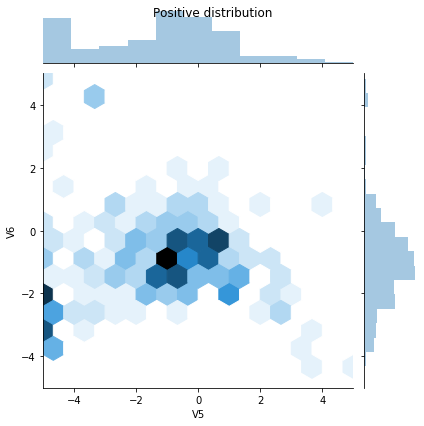

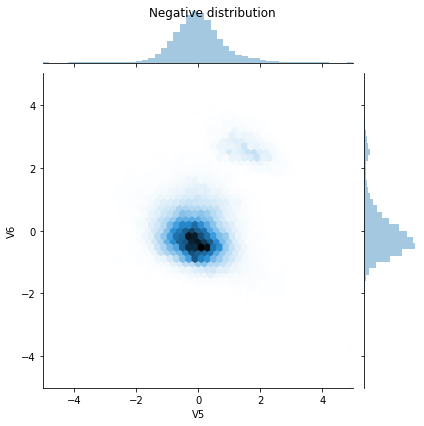

In [8]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns = train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns = train_df.columns)

sns.jointplot(pos_df['V5'], pos_df['V6'],
              kind='hex', xlim = (-5,5), ylim = (-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(neg_df['V5'], neg_df['V6'],
              kind='hex', xlim = (-5,5), ylim = (-5,5))
_ = plt.suptitle("Negative distribution")

In [15]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics = METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
    ])

    model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

    return model

In [16]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [17]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                480       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.predict(train_features[:10])

array([[0.13143423],
       [0.30635965],
       [0.04417047],
       [0.19670966],
       [0.04922184],
       [0.3187629 ],
       [0.13788885],
       [0.05474365],
       [0.10838839],
       [0.06368983]], dtype=float32)

In [19]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.2315


In [20]:
initial_bias = np.log([pos/neg])
initial_bias

array([-6.35935934])

In [21]:
model = make_model(output_bias = initial_bias)
model.predict(train_features[:10])

array([[0.00516704],
       [0.00121948],
       [0.00051078],
       [0.00133124],
       [0.00175214],
       [0.00078428],
       [0.00270781],
       [0.00052324],
       [0.00176489],
       [0.00057811]], dtype=float32)

In [22]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0136


In [23]:
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)

In [24]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [25]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [26]:
def plot_loss(history, label, n):
    # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
    plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend()

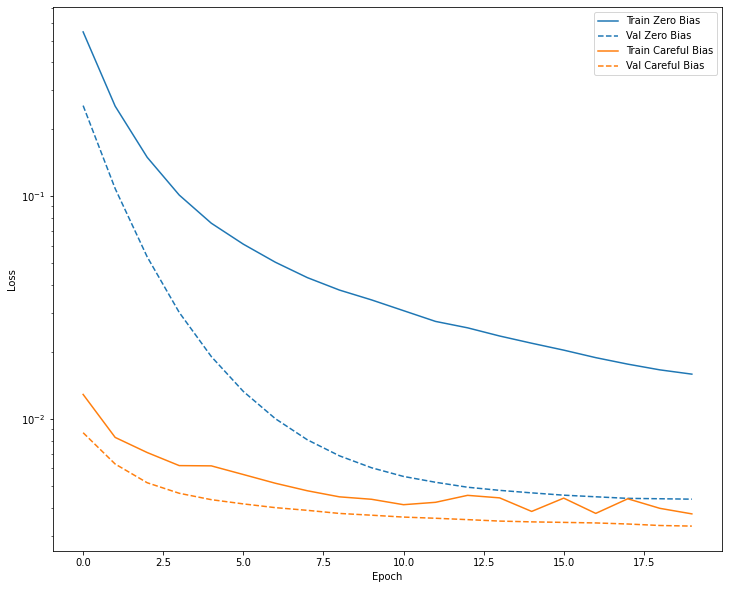

In [27]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [28]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100
90/90 [==============================] - 4s 20ms/step - loss: 0.0140 - tp: 80.7033 - fp: 55.9231 - tn: 139416.3516 - fn: 156.5934 - accuracy: 0.9986 - precision: 0.6046 - recall: 0.3875 - auc: 0.7852 - val_loss: 0.0084 - val_tp: 1.0000 - val_fp: 0.0000e+00 - val_tn: 45478.0000 - val_fn: 90.0000 - val_accuracy: 0.9980 - val_precision: 1.0000 - val_recall: 0.0110 - val_auc: 0.9002
Epoch 2/100
90/90 [==============================] - 1s 10ms/step - loss: 0.0093 - tp: 33.4615 - fp: 16.7253 - tn: 93963.7253 - fn: 126.6593 - accuracy: 0.9984 - precision: 0.5922 - recall: 0.1768 - auc: 0.7686 - val_loss: 0.0062 - val_tp: 31.0000 - val_fp: 6.0000 - val_tn: 45472.0000 - val_fn: 60.0000 - val_accuracy: 0.9986 - val_precision: 0.8378 - val_recall: 0.3407 - val_auc: 0.9119
Epoch 3/100
90/90 [==============================] - 1s 11ms/step - loss: 0.0072 - tp: 55.0000 - fp: 13.0440 - tn: 93972.5165 - fn: 100.0110 - accuracy: 0.9988 - precision: 0.7894 - recall: 0.3449 - auc: 0.8238 - val

90/90 [==============================] - 1s 13ms/step - loss: 0.0039 - tp: 93.8791 - fp: 16.8462 - tn: 93963.0989 - fn: 66.7473 - accuracy: 0.9991 - precision: 0.8716 - recall: 0.5917 - auc: 0.9414 - val_loss: 0.0034 - val_tp: 63.0000 - val_fp: 4.0000 - val_tn: 45474.0000 - val_fn: 28.0000 - val_accuracy: 0.9993 - val_precision: 0.9403 - val_recall: 0.6923 - val_auc: 0.9448
Epoch 23/100
90/90 [==============================] - 1s 11ms/step - loss: 0.0044 - tp: 89.1319 - fp: 14.0879 - tn: 93970.0549 - fn: 67.2967 - accuracy: 0.9991 - precision: 0.8697 - recall: 0.5604 - auc: 0.9159 - val_loss: 0.0033 - val_tp: 69.0000 - val_fp: 4.0000 - val_tn: 45474.0000 - val_fn: 22.0000 - val_accuracy: 0.9994 - val_precision: 0.9452 - val_recall: 0.7582 - val_auc: 0.9448
Epoch 24/100
90/90 [==============================] - 1s 11ms/step - loss: 0.0038 - tp: 91.1099 - fp: 12.4286 - tn: 93975.7582 - fn: 61.2747 - accuracy: 0.9992 - precision: 0.8659 - recall: 0.5725 - auc: 0.9166 - val_loss: 0.0033 - v

90/90 [==============================] - 1s 13ms/step - loss: 0.0035 - tp: 96.4066 - fp: 9.8352 - tn: 93973.2747 - fn: 61.0549 - accuracy: 0.9993 - precision: 0.9223 - recall: 0.6050 - auc: 0.9240 - val_loss: 0.0033 - val_tp: 64.0000 - val_fp: 4.0000 - val_tn: 45474.0000 - val_fn: 27.0000 - val_accuracy: 0.9993 - val_precision: 0.9412 - val_recall: 0.7033 - val_auc: 0.9449
Epoch 44/100
90/90 [==============================] - 1s 12ms/step - loss: 0.0038 - tp: 94.1868 - fp: 16.3846 - tn: 93967.1978 - fn: 62.8022 - accuracy: 0.9991 - precision: 0.8572 - recall: 0.5895 - auc: 0.9283 - val_loss: 0.0033 - val_tp: 64.0000 - val_fp: 4.0000 - val_tn: 45474.0000 - val_fn: 27.0000 - val_accuracy: 0.9993 - val_precision: 0.9412 - val_recall: 0.7033 - val_auc: 0.9394
Epoch 45/100
90/90 [==============================] - 1s 10ms/step - loss: 0.0036 - tp: 93.0659 - fp: 16.9121 - tn: 93968.0989 - fn: 62.4945 - accuracy: 0.9992 - precision: 0.8510 - recall: 0.6151 - auc: 0.9417 - val_loss: 0.0033 - va

In [29]:
def plot_metrics(history):
    metrics =  ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()

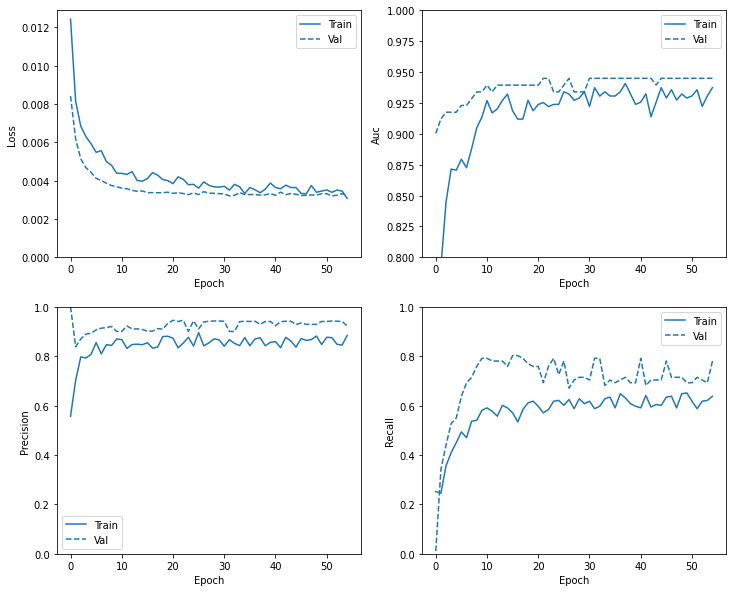

In [30]:
plot_metrics(baseline_history)

In [31]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [32]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  0.003802577266469598
tp :  69.0
fp :  5.0
tn :  56854.0
fn :  34.0
accuracy :  0.9993153214454651
precision :  0.9324324131011963
recall :  0.6699029207229614
auc :  0.9124011397361755

Legitimate Transactions Detected (True Negatives):  56854
Legitimate Transactions Incorrectly Detected (False Positives):  5
Fraudulent Transactions Missed (False Negatives):  34
Fraudulent Transactions Detected (True Positives):  69
Total Fraudulent Transactions:  103


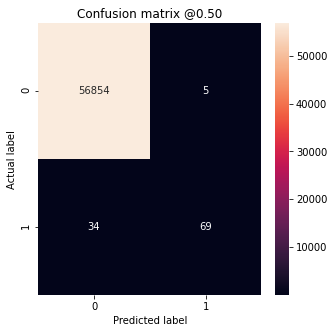

In [33]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

In [34]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

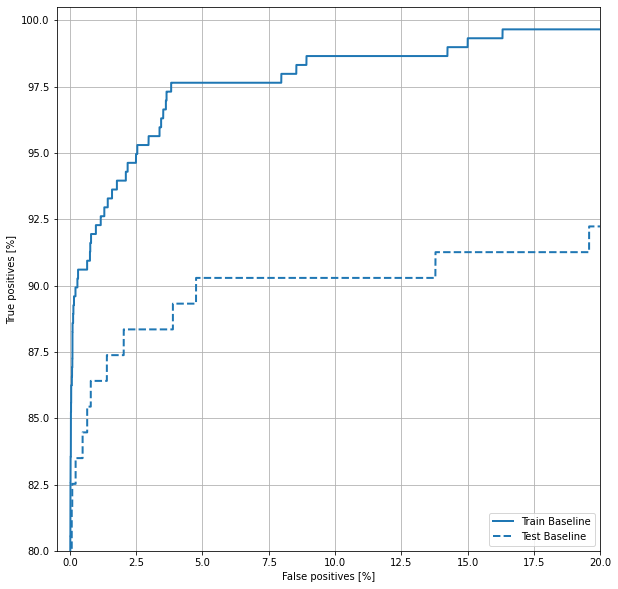

In [35]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [36]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


In [37]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight) 

Epoch 1/100
90/90 [==============================] - 4s 21ms/step - loss: 2.8740 - tp: 85.8571 - fp: 148.2857 - tn: 150690.6813 - fn: 177.7473 - accuracy: 0.9980 - precision: 0.4396 - recall: 0.3511 - auc: 0.7679 - val_loss: 0.0098 - val_tp: 33.0000 - val_fp: 19.0000 - val_tn: 45459.0000 - val_fn: 58.0000 - val_accuracy: 0.9983 - val_precision: 0.6346 - val_recall: 0.3626 - val_auc: 0.9224
Epoch 2/100
90/90 [==============================] - 1s 13ms/step - loss: 1.5580 - tp: 63.5824 - fp: 269.5055 - tn: 93712.3407 - fn: 95.1429 - accuracy: 0.9963 - precision: 0.1921 - recall: 0.3761 - auc: 0.7723 - val_loss: 0.0105 - val_tp: 53.0000 - val_fp: 37.0000 - val_tn: 45441.0000 - val_fn: 38.0000 - val_accuracy: 0.9984 - val_precision: 0.5889 - val_recall: 0.5824 - val_auc: 0.9355
Epoch 3/100
90/90 [==============================] - 1s 13ms/step - loss: 1.0609 - tp: 75.4615 - fp: 478.8791 - tn: 93513.7033 - fn: 72.5275 - accuracy: 0.9942 - precision: 0.1293 - recall: 0.4779 - auc: 0.8352 - val

Epoch 22/100
90/90 [==============================] - 1s 14ms/step - loss: 0.2277 - tp: 127.2857 - fp: 3422.5165 - tn: 90572.7143 - fn: 18.0549 - accuracy: 0.9638 - precision: 0.0340 - recall: 0.8509 - auc: 0.9689 - val_loss: 0.0781 - val_tp: 85.0000 - val_fp: 878.0000 - val_tn: 44600.0000 - val_fn: 6.0000 - val_accuracy: 0.9806 - val_precision: 0.0883 - val_recall: 0.9341 - val_auc: 0.9874
Epoch 23/100
90/90 [==============================] - 1s 11ms/step - loss: 0.2372 - tp: 134.4945 - fp: 3430.0440 - tn: 90561.7912 - fn: 14.2418 - accuracy: 0.9631 - precision: 0.0379 - recall: 0.9026 - auc: 0.9638 - val_loss: 0.0744 - val_tp: 85.0000 - val_fp: 836.0000 - val_tn: 44642.0000 - val_fn: 6.0000 - val_accuracy: 0.9815 - val_precision: 0.0923 - val_recall: 0.9341 - val_auc: 0.9873
Epoch 24/100
90/90 [==============================] - 1s 11ms/step - loss: 0.1896 - tp: 135.2527 - fp: 3258.3956 - tn: 90731.6264 - fn: 15.2967 - accuracy: 0.9654 - precision: 0.0393 - recall: 0.9080 - auc: 0.975

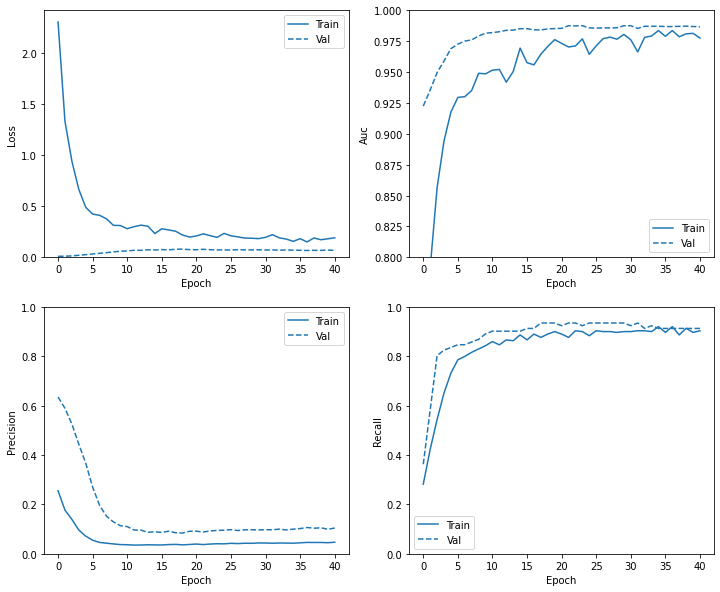

In [38]:
plot_metrics(weighted_history)

In [39]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.08400702202398788
tp :  98.0
fp :  1013.0
tn :  55842.0
fn :  9.0
accuracy :  0.9820582
precision :  0.088208824
recall :  0.91588783
auc :  0.98585856

Legitimate Transactions Detected (True Negatives):  55842
Legitimate Transactions Incorrectly Detected (False Positives):  1013
Fraudulent Transactions Missed (False Negatives):  9
Fraudulent Transactions Detected (True Positives):  98
Total Fraudulent Transactions:  107


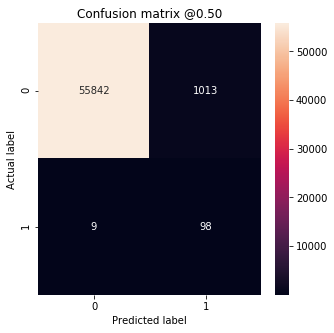

In [43]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

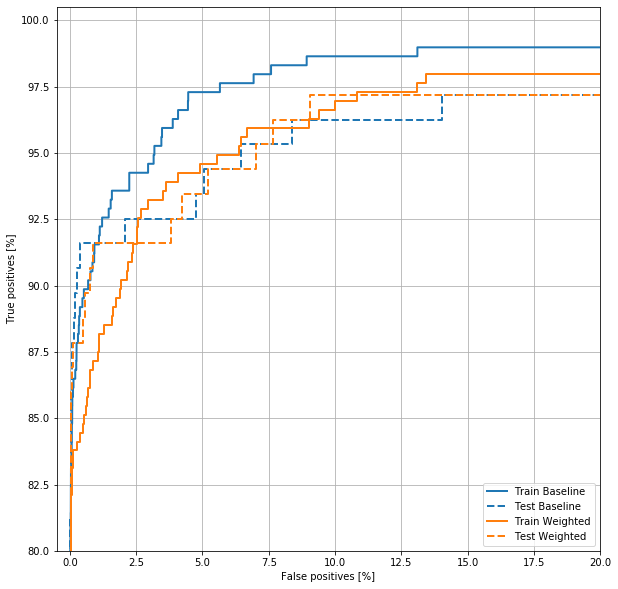

In [44]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')

In [45]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

In [46]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(181980, 29)

In [47]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(363960, 29)

In [48]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
    ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
    ds = ds.shuffle(BUFFER_SIZE).repeat()
    return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [49]:
for features, label in pos_ds.take(1):
    print("Features:\n", features.numpy())
    print()
    print("Label: ", label.numpy())

Features:
 [ 0.61011847 -0.34680698  0.48951702 -0.00883998 -0.44614368  0.6200226
 -0.66646728  0.22571364  1.0625577  -0.34336461 -0.23959719  1.38648389
  0.87630566 -0.86519872 -1.69448344  0.14412605 -0.48154642  0.32415786
  1.50621315  0.08180768 -0.06680776  0.28676643 -0.42940346 -1.12013466
  0.98338756  2.58918969 -0.07121673 -0.02064647  0.25914782]

Label:  1


In [50]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [51]:
for features, label in resampled_ds.take(1):
    print(label.numpy().mean())

0.4912109375


In [52]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

278.0

In [53]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks = [early_stopping],
    validation_data=val_ds)

Train for 278.0 steps, validate for 23 steps
Epoch 1/100
278/278 [==============================] - 20s 73ms/step - loss: 0.4185 - tp: 226463.0000 - fp: 52914.0000 - tn: 232043.0000 - fn: 57924.0000 - accuracy: 0.8053 - precision: 0.8106 - recall: 0.7963 - auc: 0.8802 - val_loss: 0.2012 - val_tp: 81.0000 - val_fp: 783.0000 - val_tn: 44697.0000 - val_fn: 8.0000 - val_accuracy: 0.9826 - val_precision: 0.0938 - val_recall: 0.9101 - val_auc: 0.9745
Epoch 2/100
278/278 [==============================] - 17s 60ms/step - loss: 0.2151 - tp: 249545.0000 - fp: 15956.0000 - tn: 269519.0000 - fn: 34324.0000 - accuracy: 0.9117 - precision: 0.9399 - recall: 0.8791 - auc: 0.9684 - val_loss: 0.1202 - val_tp: 82.0000 - val_fp: 745.0000 - val_tn: 44735.0000 - val_fn: 7.0000 - val_accuracy: 0.9835 - val_precision: 0.0992 - val_recall: 0.9213 - val_auc: 0.9750
Epoch 3/100
278/278 [==============================] - 17s 60ms/step - loss: 0.1712 - tp: 255288.0000 - fp: 11069.0000 - tn: 273457.0000 - fn: 2953

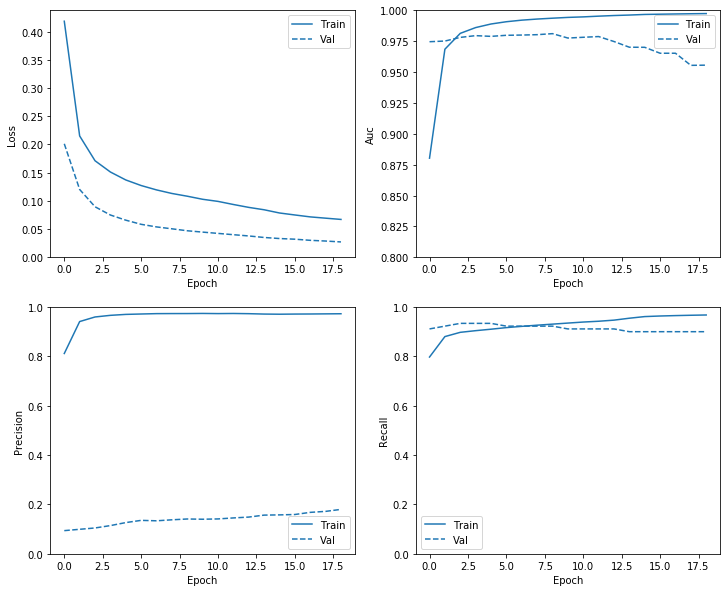

In [54]:
plot_metrics(resampled_history )

In [55]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch = 20,
    
    epochs=10*EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_ds))

Train for 20 steps, validate for 23 steps
Epoch 1/1000
20/20 [==============================] - 9s 437ms/step - loss: 1.0385 - tp: 8901.0000 - fp: 6159.0000 - tn: 14396.0000 - fn: 11504.0000 - accuracy: 0.5688 - precision: 0.5910 - recall: 0.4362 - auc: 0.5366 - val_loss: 0.4960 - val_tp: 64.0000 - val_fp: 8404.0000 - val_tn: 37076.0000 - val_fn: 25.0000 - val_accuracy: 0.8150 - val_precision: 0.0076 - val_recall: 0.7191 - val_auc: 0.8000
Epoch 2/1000
20/20 [==============================] - 1s 60ms/step - loss: 0.6199 - tp: 14037.0000 - fp: 6634.0000 - tn: 13926.0000 - fn: 6363.0000 - accuracy: 0.6827 - precision: 0.6791 - recall: 0.6881 - auc: 0.7515 - val_loss: 0.5018 - val_tp: 73.0000 - val_fp: 8692.0000 - val_tn: 36788.0000 - val_fn: 16.0000 - val_accuracy: 0.8089 - val_precision: 0.0083 - val_recall: 0.8202 - val_auc: 0.8790
Epoch 3/1000
20/20 [==============================] - 1s 69ms/step - loss: 0.5075 - tp: 15868.0000 - fp: 6462.0000 - tn: 14052.0000 - fn: 4578.0000 - accurac

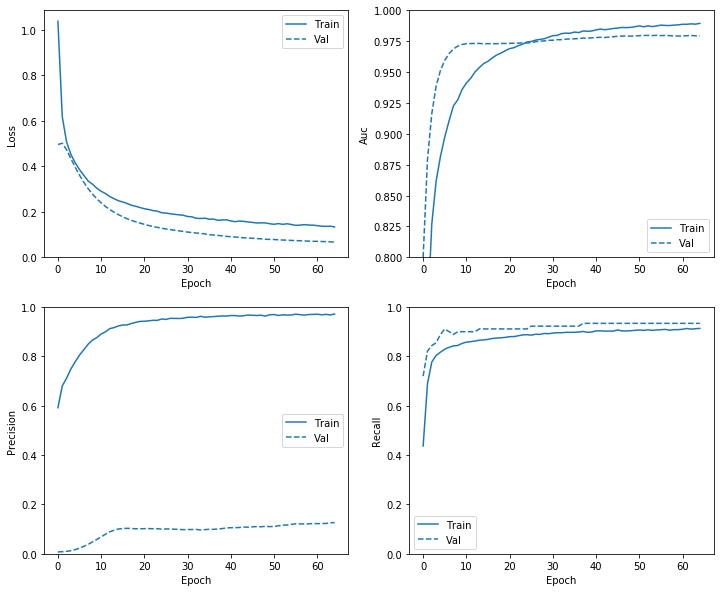

In [56]:
plot_metrics(resampled_history)

In [57]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.07542398583426083
tp :  98.0
fp :  776.0
tn :  56079.0
fn :  9.0
accuracy :  0.98621887
precision :  0.112128146
recall :  0.91588783
auc :  0.98667455

Legitimate Transactions Detected (True Negatives):  56079
Legitimate Transactions Incorrectly Detected (False Positives):  776
Fraudulent Transactions Missed (False Negatives):  9
Fraudulent Transactions Detected (True Positives):  98
Total Fraudulent Transactions:  107


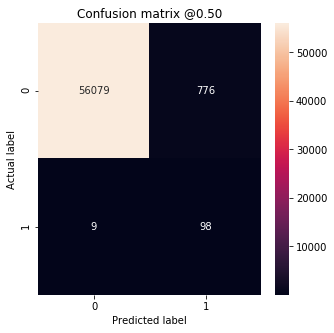

In [58]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

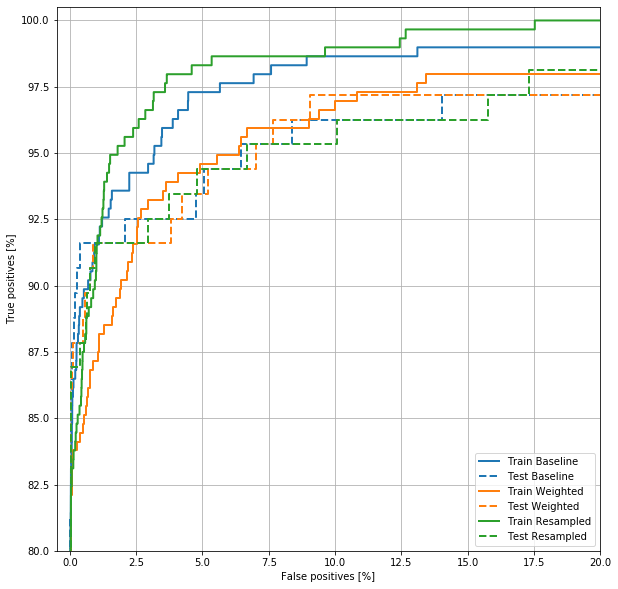

In [59]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled,  color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled,  color=colors[2], linestyle='--')
plt.legend(loc='lower right')